# Figures
Use `micromamba activate benchmark_env`.

In [10]:
library(ggplot2)
library(tidyverse)
library(ggridges)
library(repr)

# Histogrma to show p-values are sysematically smaller for gpt-4o than for gpt-3.5.

In [2]:
df <- readr::read_tsv("genes_overlap.tsv")

Rows: 34512 Columns: 13
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): database, model, gene_set, descr
dbl (9): ncurated, nllm, ninter, generatio, bgratio, non_hgcn, ndup, p_val, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Warning message in geom_histogram(bin = n_bins, fill = "blue", color = "black"):
“Ignoring unknown parameters: `bin`”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 12 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_bar()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 12 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_bar()`).”


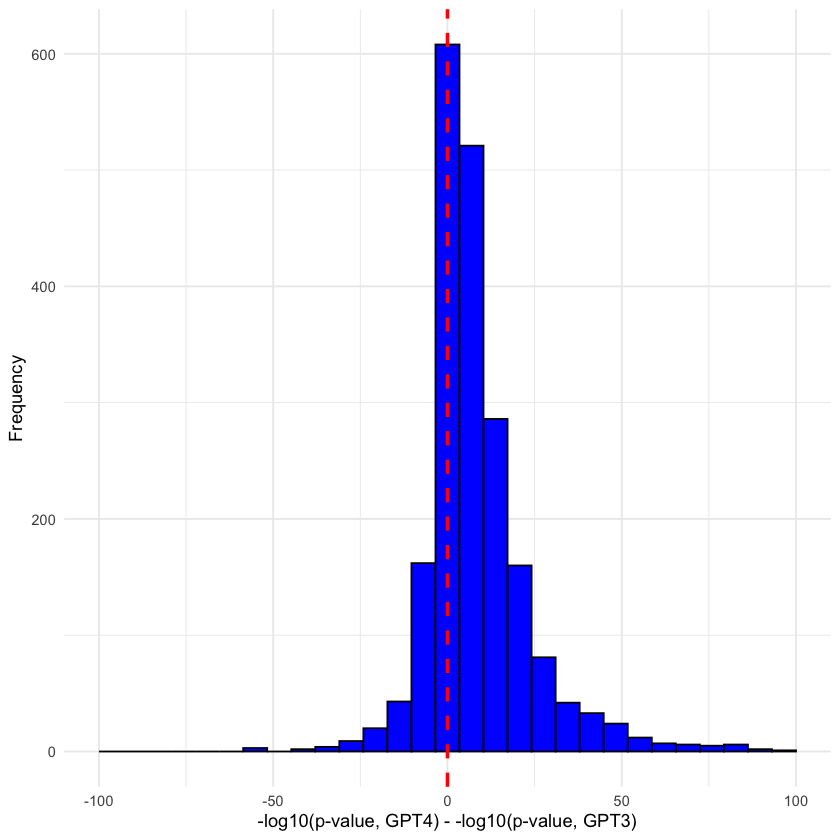

In [6]:
df <- df |> dplyr::filter(p_val_adj < 0.01)
df <- df |> dplyr::filter(gene_set == "llm_genes_role") 
#df <- df |> dplyr::filter(database=="WikiPathway_2023_Human")
df.gpt3 <- df |> dplyr::filter(model == "gpt-3.5-turbo-0125")
df.gpt4 <- df |> dplyr::filter(model == "gpt-4o-2024-05-13")

df.m <- merge(df.gpt3, df.gpt4, by="descr", suffixes = c(".gpt3", ".gpt4"))
df.m$p_val.gpt3 <- -log10(df.m$p_val.gpt3)
df.m$p_val.gpt4 <- -log10(df.m$p_val.gpt4)

df.m$diff <- df.m$p_val.gpt4 - df.m$p_val.gpt3 

freedman_diaconis_bins <- function(x) {
  h <- 2 * IQR(x) / (length(x)^(1/3))
  n_bins <- ceiling((max(x) - min(x)) / h)
  return(n_bins)
}
n_bins <- freedman_diaconis_bins(df.m$diff)

fig <- ggplot(df.m, aes(x = diff)) +
  geom_histogram(bin = n_bins, fill = "blue", color = "black") +
  geom_vline(aes(xintercept = 0), color = "red", linetype = "dashed", size = 1) +
  xlim(-100, 100) +
  labs(x = "-log10(p-value, GPT4) - -log10(p-value, GPT3)",
       y = "Frequency") +
  theme_minimal()
ggsave(fig, file="figures/p_value_diff_histogram.pdf", width = 4, height=4)
fig 

Plot to show generation times in seconds for various experiments.

Rows: 6 Columns: 4
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): lib_name, model
dbl (2): gen_time_role, gen_time_reason

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Saving 7 x 7 in image


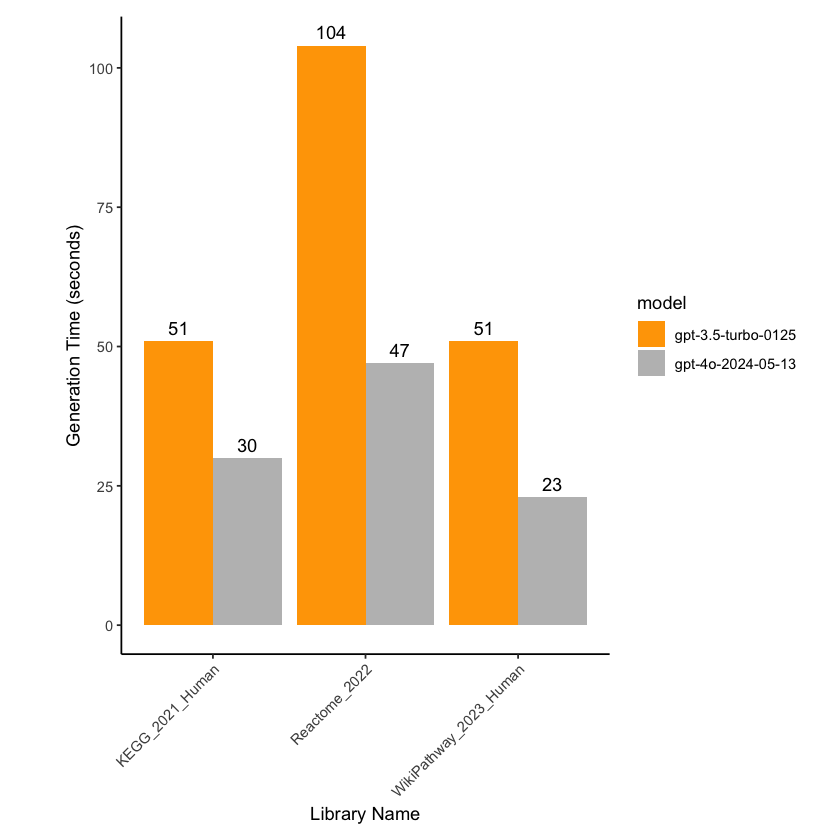

In [5]:
data <- readr::read_tsv("gen_time.tsv")
data$gen_time_role <- round(data$gen_time_role)

gen_fig <- ggplot(data, aes(x = lib_name, y = gen_time_role, fill = model)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  geom_text(aes(label = gen_time_role), position = position_dodge(width = 0.9), vjust = -0.5) +
  labs(x = "Library Name", y = "Generation Time (seconds)") +
  theme_classic() +
  scale_fill_manual(values = c("gpt-3.5-turbo-0125" = "orange", "gpt-4o-2024-05-13" = "gray")) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.margin = margin(10, 10, 10, 40)
  )

ggsave(gen_fig, file="figures/gen_plot.pdf")
gen_fig

Rows: 12 Columns: 4
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): lib_name, model
dbl (2): in_toks, out_toks

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


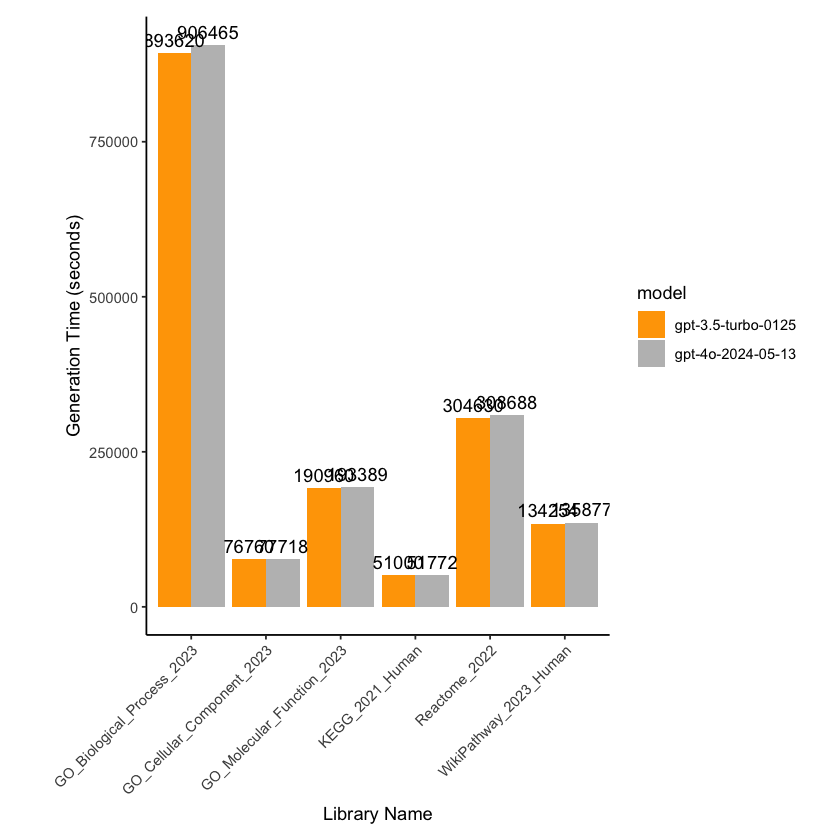

In [3]:
data <- readr::read_tsv("tok_use.tsv")

gen_fig <- ggplot(data, aes(x = lib_name, y = in_toks, fill = model)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  geom_text(aes(label = in_toks), position = position_dodge(width = 0.9), vjust = -0.5) +
  labs(x = "Library Name", y = "Generation Time (seconds)") +
  theme_classic() +
  scale_fill_manual(values = c("gpt-3.5-turbo-0125" = "orange", "gpt-4o-2024-05-13" = "gray")) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.margin = margin(10, 10, 10, 40)
  )

#ggsave(gen_fig, file="figures/gen_plot.pdf")
gen_fig

In [16]:
# Group by model and sum in_toks and out_toks
summarized_df <- data %>%
  group_by(model) %>%
  summarise(
    total_in_toks = sum(in_toks, na.rm = TRUE),
    total_out_toks = sum(out_toks, na.rm = TRUE)
  )
summarized_df

model,total_in_toks,total_out_toks
<chr>,<dbl>,<dbl>
gpt-3.5-turbo-0125,1651224,1633856
gpt-4o-2024-05-13,1673909,2893144


# Show sift in precision for confidence and ensembling.

In [11]:
df <- readr::read_tsv("genes_overlap.tsv")
unique(df$model)

Rows: 34512 Columns: 14
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (4): database, model, gene_set, descr
dbl (10): ncurated, nllm, ninter, generatio, bgratio, non_hgcn, ntries, ndup...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "gpt-3.5-turbo-0125" "gpt-4o-2024-05-13"

Warning message in geom_density_ridges(scale = 0.95, alpha = 0.7, color = "black", :
“Ignoring unknown parameters: `size`”
Picking joint bandwidth of 0.0608

Picking joint bandwidth of 0.0608



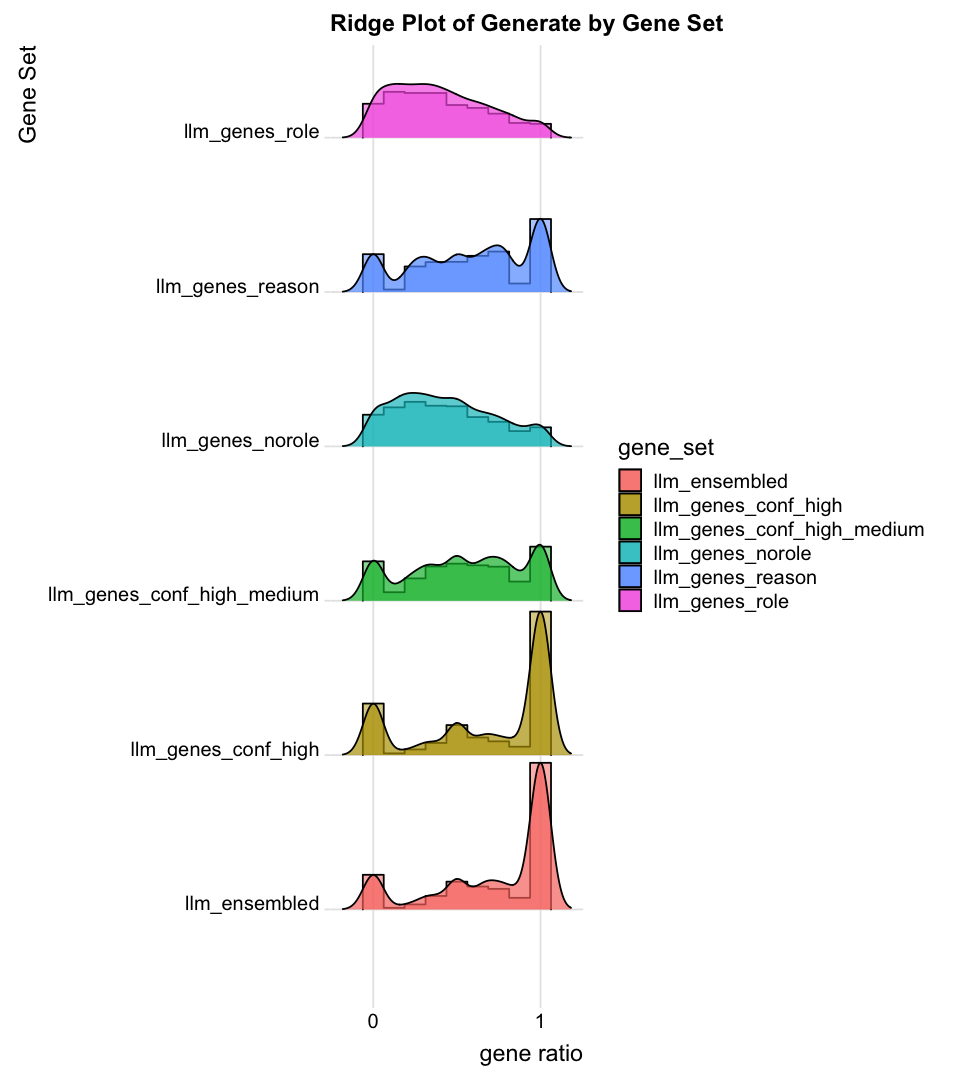

In [12]:

fig <- ggplot(df |> filter(model=="gpt-3.5-turbo-0125"), aes(x = generatio, y = gene_set, fill = gene_set)) +
  geom_density_ridges(stat = "binline", bins = 9, scale = 0.95, draw_baseline = FALSE, alpha = 0.5) +
  geom_density_ridges(scale = 0.95, alpha = 0.7, color = "black", size = 0.3) +
  theme_ridges() + 
  labs(title = "Ridge Plot of Generate by Gene Set",
       x = "gene ratio",
       y = "Gene Set") +
scale_x_continuous(breaks = c(0, 1))

ggsave(fig, file="gene_ratio_gpt3.pdf", width=10,height=16)

options(repr.plot.width = 8, repr.plot.height = 9)  # Width = 10 inches, Height = 6 inches

fig


Warning message in geom_density_ridges(scale = 0.95, alpha = 0.7, color = "black", :
“Ignoring unknown parameters: `size`”
Picking joint bandwidth of 0.049

Picking joint bandwidth of 0.049



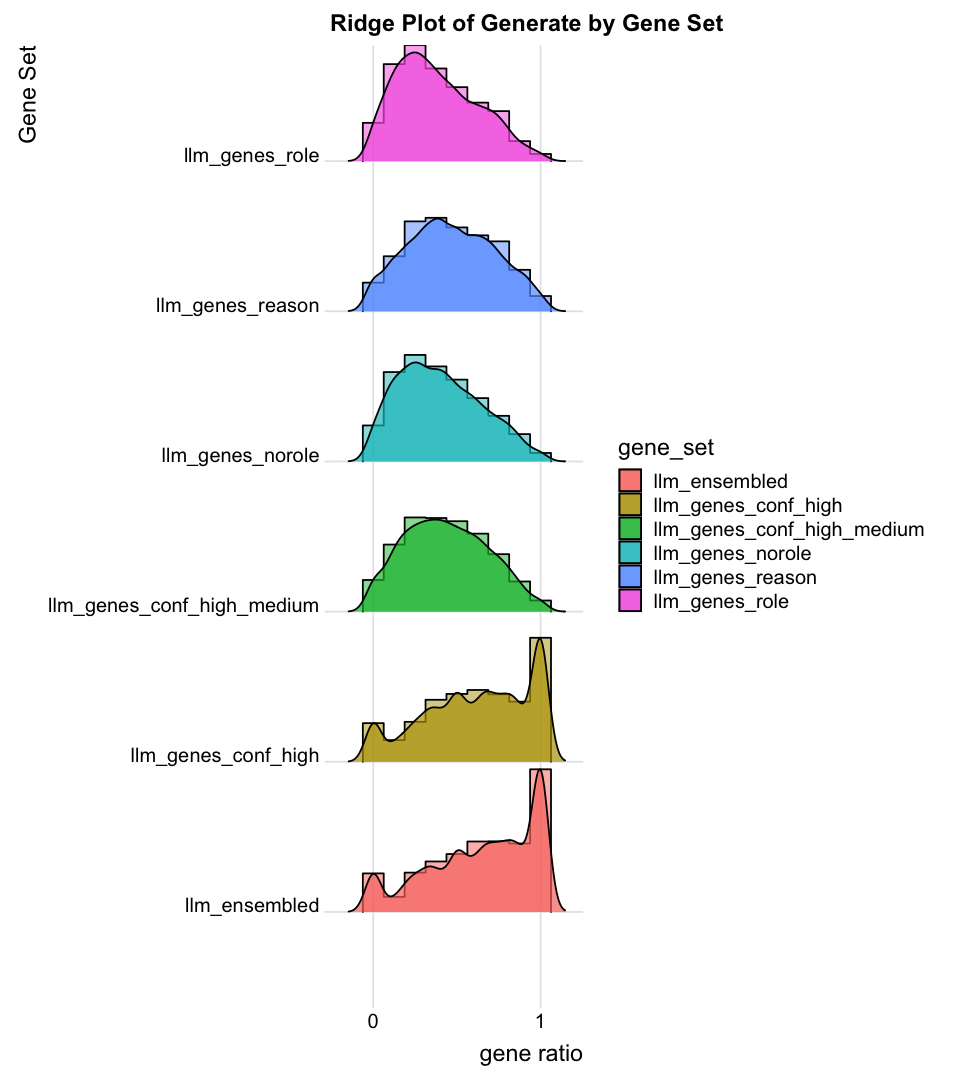

In [13]:

fig <- ggplot(df |> filter(model=="gpt-4o-2024-05-13"), aes(x = generatio, y = gene_set, fill = gene_set)) +
  geom_density_ridges(stat = "binline", bins = 9, scale = 0.95, draw_baseline = FALSE, alpha = 0.5) +
  geom_density_ridges(scale = 0.95, alpha = 0.7, color = "black", size = 0.3) +
  theme_ridges() + 
  labs(title = "Ridge Plot of Generate by Gene Set",
       x = "gene ratio",
       y = "Gene Set") +
scale_x_continuous(breaks = c(0, 1))

ggsave(fig, file="gene_ratio_gpt4.pdf", width=10,height=16)

options(repr.plot.width = 8, repr.plot.height = 9)  # Width = 10 inches, Height = 6 inches

fig


# Fraction of significant gene sets

In [14]:
df <- readr::read_tsv("genes_overlap.tsv")

Rows: 34512 Columns: 14
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (4): database, model, gene_set, descr
dbl (10): ncurated, nllm, ninter, generatio, bgratio, non_hgcn, ntries, ndup...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [15]:
df.gpt4 <- df |> filter(model == "gpt-4o-2024-05-13")
df.gpt3 <- df |> filter(model == "gpt-3.5-turbo-0125")

In [16]:
colnames(df.gpt4)

[1] "database"  "model"     "gene_set"  "descr"     "ncurated"  "nllm"     
 [7] "ninter"    "generatio" "bgratio"   "non_hgcn"  "ntries"    "ndup"     
[13] "p_val"     "p_val_adj"

In [17]:
res.gpt4 <- df.gpt4 %>%
  group_by(database, gene_set) %>%
  summarise(fraction = mean(p_val_adj < 0.01, na.rm = TRUE))
res.gpt3 <- df.gpt3 %>%
  group_by(database, gene_set) %>%
  summarise(fraction = mean(p_val_adj < 0.01, na.rm = TRUE))

`summarise()` has grouped output by 'database'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'database'. You can override using the `.groups` argument.


In [18]:
res.gpt4

database,gene_set,fraction
<chr>,<chr>,<dbl>
KEGG_2021_Human,llm_ensembled,0.8360129
KEGG_2021_Human,llm_genes_conf_high,0.8683386
KEGG_2021_Human,llm_genes_conf_high_medium,0.9156250
KEGG_2021_Human,llm_genes_norole,0.9312500
KEGG_2021_Human,llm_genes_reason,0.9062500
KEGG_2021_Human,llm_genes_role,0.9468750
Reactome_2022,llm_ensembled,0.7028112
Reactome_2022,llm_genes_conf_high,0.7244224
Reactome_2022,llm_genes_conf_high_medium,0.8030803


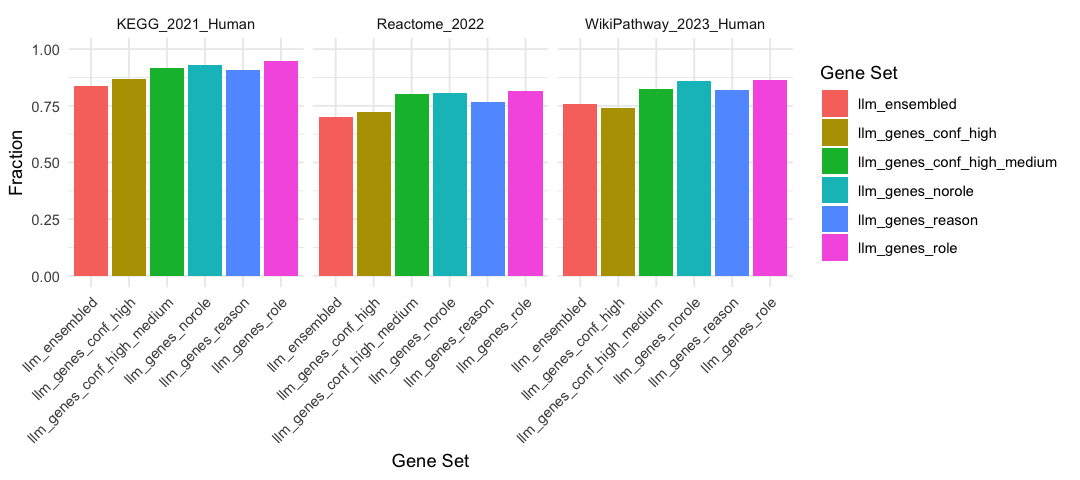

In [19]:
options(repr.plot.width = 9, repr.plot.height = 4)  
fig <- ggplot(res.gpt4, aes(x = gene_set, y = fraction, fill = gene_set)) +
  geom_bar(stat = "identity") +
  labs(x = "Gene Set", y = "Fraction", fill = "Gene Set") +
  facet_wrap(~database) +
  ylim(0,1) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
ggsave(fig, file="gpt4_over.pdf", width=9, height=4)
fig 

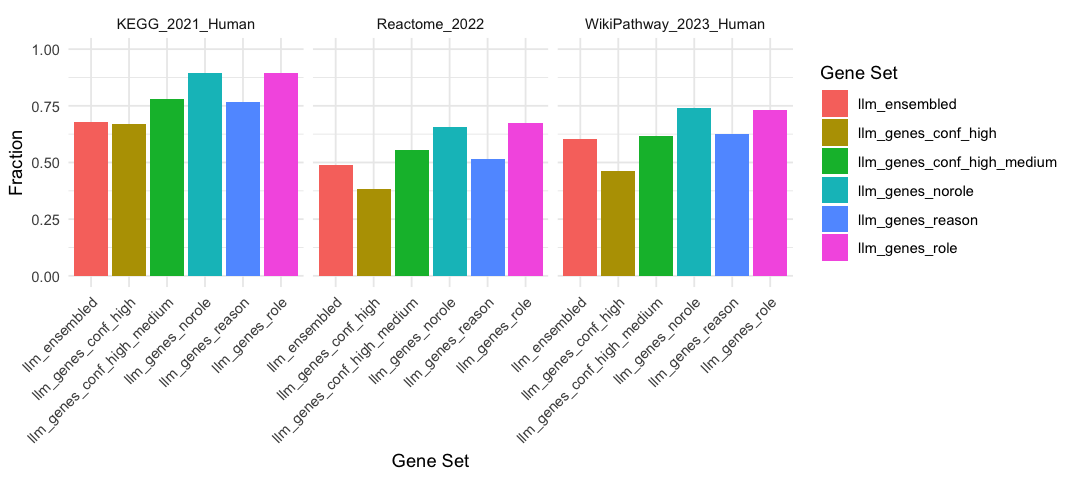

In [20]:
options(repr.plot.width = 9, repr.plot.height = 4)  
fig <- ggplot(res.gpt3, aes(x = gene_set, y = fraction, fill = gene_set)) +
  geom_bar(stat = "identity") +
  labs(x = "Gene Set", y = "Fraction", fill = "Gene Set") +
  facet_wrap(~database) +
  ylim(0,1) +
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
ggsave(fig, file="gpt3_over.pdf", width=9, height=4)
fig 

# Fraction of significant gene sets comparing role prompt vs no role prompt

In [2]:
df <- readr::read_tsv("genes_overlap.tsv")
unique(df$gene_set)

Rows: 34512 Columns: 13
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): database, model, gene_set, descr
dbl (9): ncurated, nllm, ninter, generatio, bgratio, non_hgcn, ndup, p_val, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "llm_genes_role"             "llm_genes_norole"          
[3] "llm_genes_reason"           "llm_genes_conf_high"       
[5] "llm_genes_conf_high_medium" "llm_ensembled"

In [3]:
df <- df |> filter(gene_set %in% c("llm_genes_role", "llm_genes_norole"))

In [4]:
df <- df %>%
  group_by(database, gene_set, model) %>%
  summarise(fraction = mean(p_val_adj < 0.01, na.rm = TRUE))

`summarise()` has grouped output by 'database', 'gene_set'. You can override using the `.groups` argument.


In [5]:
df

database,gene_set,model,fraction
<chr>,<chr>,<chr>,<dbl>
KEGG_2021_Human,llm_genes_norole,gpt-3.5-turbo-0125,0.8968750
KEGG_2021_Human,llm_genes_norole,gpt-4o-2024-05-13,0.9312500
KEGG_2021_Human,llm_genes_role,gpt-3.5-turbo-0125,0.8968750
KEGG_2021_Human,llm_genes_role,gpt-4o-2024-05-13,0.9468750
Reactome_2022,llm_genes_norole,gpt-3.5-turbo-0125,0.6571271
Reactome_2022,llm_genes_norole,gpt-4o-2024-05-13,0.8067181
Reactome_2022,llm_genes_role,gpt-3.5-turbo-0125,0.6719956
Reactome_2022,llm_genes_role,gpt-4o-2024-05-13,0.8164278
WikiPathway_2023_Human,llm_genes_norole,gpt-3.5-turbo-0125,0.7396746


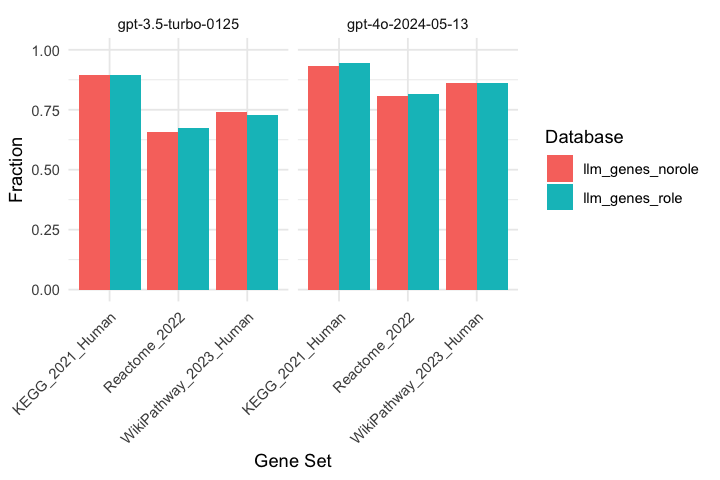

In [9]:
options(repr.plot.width = 6, repr.plot.height = 4)  
fig <- ggplot(df, aes(x = database, y = fraction, fill = gene_set)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "Gene Set", y = "Fraction", fill = "Database") +
  facet_wrap(~model) +
  ylim(0, 1) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

ggsave(fig, file="role_vs_norole.pdf", width=6, height=4)
fig